In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tweepy,json
from tweepy import OAuthHandler
import datetime,math
from google.colab import files
from dateutil.parser import parse
import pytz,pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pandas.io.json import json_normalize
import csv
import networkx as nx
from operator import itemgetter
import community #This is the python-louvain package we installed.
import community.community_louvain as cm
import matplotlib.pyplot as plt
import networkx as nx

!pip install pyvis

import pyvis
from pyvis.network import Network

In [ ]:
secrets = json.loads(open('/content/drive/MyDrive/twitter_secrets.json').read())
consumer_key = secrets['consumer_key']
consumer_secret = secrets['consumer_secret']
access_token = secrets['access_token']
access_token_secret = secrets['access_token_secret']
screen_name = secrets['screen_name']

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
username_gsc = "GSCinemas"
username_tgv = "TGVCinemas"
username_mmc = "mmCineplexes"

# Part 1

# Collect ALL tweets from 2022-03-07 to 2022-03-20 (can run one shot)

---



In [ ]:
tweets = []
count = 100
startDate = datetime.datetime(2022,3,7) #The date contains year, month, day, hour, minute, second, and microsecond.
endDate = datetime.datetime(2022,3,21)

# This section is for you to learn about how the arrays in python function when using Tweepy
def queryTimeline(username,filename):
  result = api.user_timeline(username,count=count)
  for t in result:
    if t.created_at < endDate:# and t.in_reply_to_status_id == None:
      tweets.append(t)

  while(result[-1].created_at >= startDate):#
    # time.sleep(3)
    print('Last tweet collected was created at',result[-1].created_at,'Retrieving more')
    result = api.user_timeline(username,count=count,max_id=result[-1].id-1)
    for t in result:
      if t.created_at >= startDate:# and t.in_reply_to_status_id == None:
        tweets.append(t)

  #json file
  with open(filename,'w') as f:
    for t in tweets:
      f.write(json.dumps(t._json)+'\n')
  
  files.download(filename)
  print(username+'\'s all tweets downloaded.')

queryTimeline(username_gsc,'GSC_tweets.json')
queryTimeline(username_tgv,'TGV_tweets.json')
queryTimeline(username_mmc,'MMC_tweets.json')

Last tweet collected was created at 2022-03-17 03:26:50 Retrieving more
Last tweet collected was created at 2022-03-11 09:47:45 Retrieving more


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GSCinemas's all tweets downloaded.
Last tweet collected was created at 2022-03-16 10:34:59 Retrieving more
Last tweet collected was created at 2022-03-11 00:11:05 Retrieving more


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TGVCinemas's all tweets downloaded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mmCineplexes's all tweets downloaded.


# 1. Followers growth rate from 2022-03-07 to 2022-03-20 (Need to collect daily)

In [ ]:
def getFollowersNum(screen_name,filename):
  userDetails = api.get_user(screen_name)
  user = {}

  dt_string = datetime.datetime.now().strftime("%Y-%m-%d")

  followers_count = userDetails.followers_count

  user['date'] = dt_string
  user['followers_count'] = followers_count
  
  dt_string2 = datetime.datetime.now().strftime("%Y%m%d")
  with open(filename+'_audience_growth_rate_'+dt_string2+'.json','w') as f:
    f.write(json.dumps(user)+'\n')

  files.download(filename+'_audience_growth_rate_'+dt_string2+'.json')

getFollowersNum(username_gsc,"GSC")
getFollowersNum(username_tgv,"TGV")
getFollowersNum(username_mmc,"MMC")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gsc_followers_count_data = pd.read_json('GSC_followers_count.json', lines=True)
tgv_followers_count_data = pd.read_json('TGV_followers_count.json', lines=True)
mmc_followers_count_data = pd.read_json('MMC_followers_count.json', lines=True)

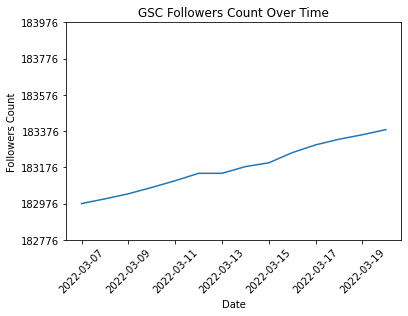

In [ ]:
#GSC
plt.plot(gsc_followers_count_data['date'], gsc_followers_count_data['followers_count'])
plt.title('GSC Followers Count Over Time')
plt.xlabel('Date')
plt.ylabel('Followers Count')
plt.yticks(range(gsc_followers_count_data['followers_count'].values[0]-200,gsc_followers_count_data['followers_count'].values[0]+1200,200))
plt.xticks(rotation ='45')
plt.show()

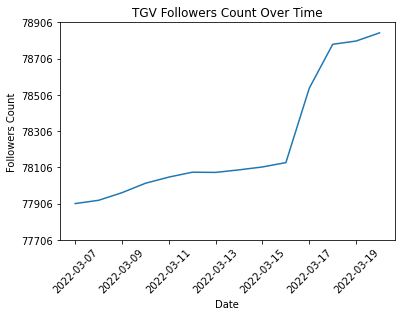

In [ ]:
#TGV
plt.plot(tgv_followers_count_data['date'], tgv_followers_count_data['followers_count'])
plt.title('TGV Followers Count Over Time')
plt.xlabel('Date')
plt.ylabel('Followers Count')
plt.yticks(range(tgv_followers_count_data['followers_count'].values[0]-200,tgv_followers_count_data['followers_count'].values[0]+1200,200))
plt.xticks(rotation ='45')
plt.show()

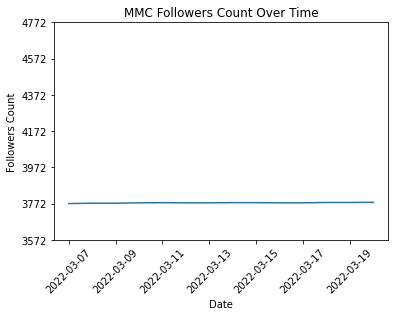

In [ ]:
#MMC
plt.plot(mmc_followers_count_data['date'], mmc_followers_count_data['followers_count'])
plt.title('MMC Followers Count Over Time')
plt.xlabel('Date')
plt.ylabel('Followers Count')
plt.yticks(range(mmc_followers_count_data['followers_count'].values[0]-200,mmc_followers_count_data['followers_count'].values[0]+1200,200))
plt.xticks(rotation ='45')
plt.show()

# 2. Active rate (Tweets per day: line chart)

In [ ]:
gsc_tweets = pd.read_json('GSC_tweets.json', lines=True)
gsc_tweets['created_at'] = gsc_tweets['created_at'].dt.strftime('%d/%m/%Y')
a = gsc_tweets.groupby("created_at").size().values
gsc_tweets= gsc_tweets.drop_duplicates(subset="created_at").assign(tweet_count=a)
gsc_tweets.drop(gsc_tweets.columns.difference(['created_at','tweet_count']), 1, inplace=True)
gsc_tweets.sort_values(by=['created_at'], inplace=True)

tgv_tweets = pd.read_json('TGV_tweets.json', lines=True)
tgv_tweets['created_at'] = tgv_tweets['created_at'].dt.strftime('%d/%m/%Y')
b = tgv_tweets.groupby("created_at").size().values
tgv_tweets= tgv_tweets.drop_duplicates(subset="created_at").assign(tweet_count=b)
tgv_tweets.drop(tgv_tweets.columns.difference(['created_at','tweet_count']), 1, inplace=True)
tgv_tweets.sort_values(by=['created_at'], inplace=True)

mmc_tweets = pd.read_json('MMC_tweets.json', lines=True)
mmc_tweets['created_at'] = mmc_tweets['created_at'].dt.strftime('%d/%m/%Y')
c = mmc_tweets.groupby("created_at").size().values
mmc_tweets= mmc_tweets.drop_duplicates(subset="created_at").assign(tweet_count=c)
mmc_tweets.drop(mmc_tweets.columns.difference(['created_at','tweet_count']), 1, inplace=True)
mmc_tweets.sort_values(by=['created_at'], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


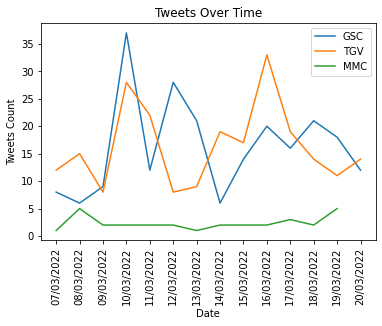

In [ ]:
plt.plot(gsc_tweets['created_at'], gsc_tweets['tweet_count'], label='GSC')
plt.plot(tgv_tweets['created_at'], tgv_tweets['tweet_count'], label='TGV')
plt.plot(mmc_tweets['created_at'], mmc_tweets['tweet_count'], label='MMC')

plt.title('Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Tweets Count')
plt.xticks(rotation ='90')
plt.legend()
plt.show()

# 3. Responsiveness

In [ ]:
avg_response_time = []
reply_count_list = []

def responsiveness(name):
  reply_time = datetime.timedelta(seconds=0)
  reply_count = 0
  user_tweets = []

  with open('/content/'+name+'_tweets.json','r') as f:
    for line in f:
      obj = json.loads(line)
      if obj['in_reply_to_status_id'] != None and obj['text'][:2] != 'RT': # replies and not retweet

        try:
          tweet = api.get_status(id=obj['in_reply_to_status_id'])
          user_tweets.append(tweet)
          tweet_created_at = datetime.datetime.strptime(tweet._json['created_at'], '%a %b %d %H:%M:%S %z %Y')
          reply_created_at = datetime.datetime.strptime(obj['created_at'], '%a %b %d %H:%M:%S %z %Y')

          reply_time += (reply_created_at - tweet_created_at)
          reply_count += 1
        except:
          print('Not authorised to access this tweet.')

  #json file
  filename = name+'_user_tweets_replied.json'
  with open(filename,'w') as f:
    for t in user_tweets:
      f.write(json.dumps(t._json)+'\n')
  files.download(filename)

  time = math.floor(reply_time.total_seconds()/60/60/reply_count)
  avg_response_time.append(time)
  reply_count_list.append(reply_count)
  print(name,'average replied in',time,'hours for',reply_count,'tweets')
  print()

responsiveness('GSC')
responsiveness('TGV')
responsiveness('MMC')

Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GSC average replied in 11 hours for 169 tweets

Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.
Not authorised to access this tweet.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TGV average replied in 5 hours for 129 tweets



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MMC average replied in 16 hours for 1 tweets



In [ ]:
cinemas = ['GSC','TGV','MMC']

avg_response_time = []
reply_count_list = []

for cinema in cinemas:
    filename_cinema = cinema+'_tweets.json'
    filename_user = cinema+'_user_tweets_replied.json'

    cinema_tweets = []
    user_tweets = []
    reply_time = datetime.timedelta(seconds=0)

    with open(filename_cinema) as f:
        for line in f:
            tweet = json.loads(line)
            cinema_tweets.append(tweet)
    with open(filename_user) as f:
        for line in f:
            tweet = json.loads(line)
            user_tweets.append(tweet)

    for tweet_user in user_tweets:
        tweet_created_at = datetime.datetime.strptime(tweet_user['created_at'], '%a %b %d %H:%M:%S %z %Y')
        
        for tweet_cinema in cinema_tweets:
            if tweet_cinema['in_reply_to_status_id'] == tweet_user['id']:
                reply_created_at = datetime.datetime.strptime(tweet_cinema['created_at'], '%a %b %d %H:%M:%S %z %Y')
        
        reply_time += (reply_created_at - tweet_created_at)

    time = math.floor(reply_time.total_seconds()/60/60/len(user_tweets))
    avg_response_time.append(time)
    reply_count_list.append(len(user_tweets))

In [ ]:
q3_df = pd.DataFrame({'Cinema':['GSC','TGV','MMC'],'Average response time (hour)':avg_response_time,'Responsed tweets':reply_count_list})

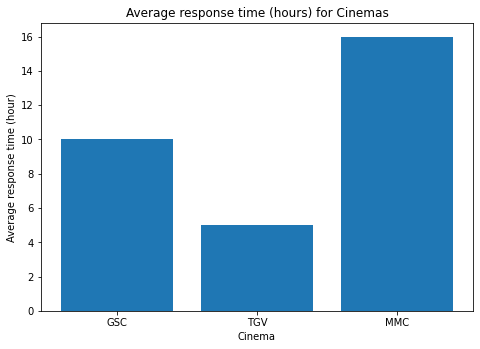

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cinema = q3_df['Cinema']
ave_resp_time = q3_df['Average response time (hour)']
ax.bar(cinema,ave_resp_time)
plt.xlabel('Cinema')
plt.ylabel('Average response time (hour)')
plt.title('Average response time (hours) for Cinemas')
plt.show()

# 4. Engagement rate per day (likes, retweets)

Engagement rates between 0.02% and 0.09% are considered to be good. An influencer with a good engagement rate on Twitter could expect between 0.2 - 0.9 reactions for every 1000 followers.

From: https://scrunch.com/blog/what-is-a-good-engagement-rate-on-twitter/

Formula: https://www.socialinsider.io/blog/content/images/2022/01/74.png

From: https://www.socialinsider.io/blog/engagement-rate/

In [ ]:
eng_rate = []
cinemas = ['GSC','TGV','MMC']

for cinema in cinemas:
    filename = cinema+'_tweets.json'
    favCount = retweetCount = total_tweet = 0

    if cinema == 'GSC':
        followers_count = gsc_followers_count_data['followers_count'].values[-1]
    elif cinema == 'TGV':
        followers_count = tgv_followers_count_data['followers_count'].values[-1]
    elif cinema == 'MMC':
        followers_count = mmc_followers_count_data['followers_count'].values[-1]

    with open(filename) as f:
        for line in f:
            tweet = json.loads(line)

            if tweet['in_reply_to_status_id'] == None: #self tweet or retweet, not reply
                total_tweet += 1
                favCount += tweet['favorite_count']
                retweetCount += tweet['retweet_count']

    engagement = (favCount + retweetCount) / total_tweet / followers_count * 100
    eng_rate.append(engagement)

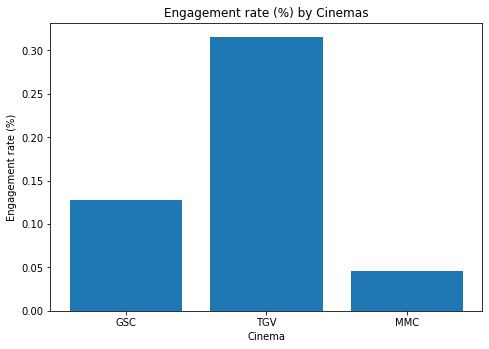

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cinemas,eng_rate)
plt.xlabel('Cinema')
plt.ylabel('Engagement rate (%)')
plt.title('Engagement rate (%) by Cinemas')
plt.show()

# 5. Top 5 hashtags used

In [ ]:
df_list = []

def getTags(tweet):
  entity = tweet.get('entities',{})
  ht = entity.get('hashtags',[])
  return [tag['text'] for tag in ht]

for cinema in cinemas:
    tag_name = []
    tag_count = []
    htags = Counter()

    filename = cinema+'_tweets.json'

    with open(filename) as f:
        for line in f:
            tweet = json.loads(line)
            if tweet['in_reply_to_status_id'] == None:
                htags.update(getTags(tweet))

    for tag, count in htags.most_common(5):
        # print(tag,count)
        tag_name.append(tag)
        tag_count.append(count)

    df_list.append(pd.DataFrame({'Tags':tag_name,'Tag Count':tag_count}))

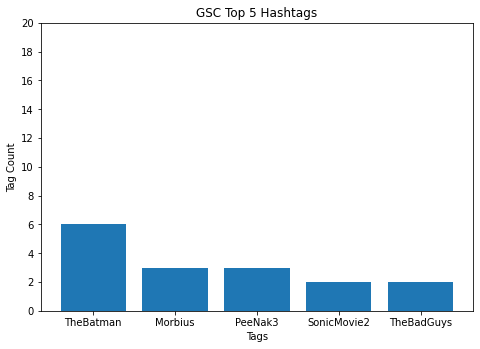

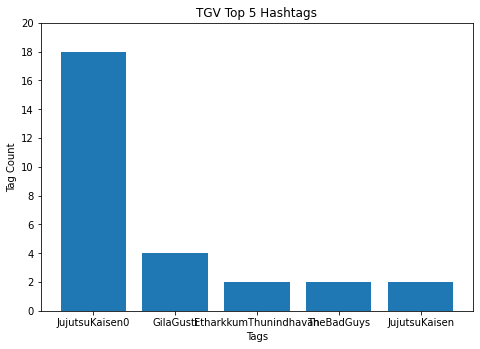

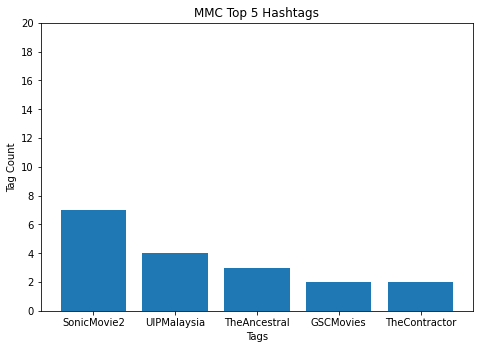

In [ ]:
for i in range(3):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  plt.bar(df_list[i]['Tags'], df_list[i]['Tag Count'])
  plt.xlabel('Tags')
  plt.ylabel('Tag Count')
  plt.yticks(range(0,21,2))
  plt.title(cinemas[i]+' Top 5 Hashtags')
  plt.show()

# Part 2 

# Data collection (Limits: 3.5k because MMC has lesser followers)

In [ ]:
usernames = [username_gsc,username_tgv,username_mmc]

In [ ]:
for username in usernames:
  with open(username+'_followers.json','w') as f:
    for page in tweepy.Cursor(api.followers, screen_name=username,count=100).pages(35):
      for user in page:
        f.write(json.dumps(user._json)+'\n')

  files.download(username+'_followers.json')

# Generate the node and edgelists from the data collected

In [ ]:
with open('GSC_followers.json') as f:
    gsc_followers_df = pd.DataFrame(json_normalize([json.loads(line) for line in f.readlines()]))

with open('TGV_followers.json') as f:
    tgv_followers_df = pd.DataFrame(json_normalize([json.loads(line) for line in f.readlines()]))

with open('MMC_followers.json') as f:
    mmc_followers_df = pd.DataFrame(json_normalize([json.loads(line) for line in f.readlines()]))

concat_df = pd.concat([gsc_followers_df, tgv_followers_df, mmc_followers_df])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [ ]:
# node list
nodes = concat_df.drop_duplicates(subset=['screen_name'])
nodes = nodes[['id_str', 'name', 'screen_name', 'location', 'description', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'time_zone', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'profile_image_url']]

# only tgv is in nodes
for name in usernames:
  print(name,len(nodes[nodes['screen_name'] == name]))

#add gsc and mmc to nodes
gsc = api.get_user(screen_name='GSCinemas')
mmc = api.get_user(screen_name='mmCineplexes')
gsc_df = pd.json_normalize(gsc._json)[['id_str', 'name', 'screen_name', 'location', 'description', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'time_zone', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'profile_image_url']]
mmc_df = pd.json_normalize(mmc._json)[['id_str', 'name', 'screen_name', 'location', 'description', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'time_zone', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'profile_image_url']]
nodes = nodes.append([gsc_df, mmc_df])

nodes.to_csv('nodeslist.csv', index=False)

GSCinemas 0
TGVCinemas 1
mmCineplexes 0


In [ ]:
# edge list
edgeslist = pd.DataFrame({'source': gsc_followers_df['screen_name'], 'destination': 'GSCinemas'})
tgv_edges = pd.DataFrame({'source': tgv_followers_df['screen_name'], 'destination': 'TGVCinemas'})
mmc_edges = pd.DataFrame({'source': mmc_followers_df['screen_name'], 'destination': 'mmCineplexes'})

edgeslist = edgeslist.append([tgv_edges, mmc_edges])
edgeslist.to_csv('edgeslist.csv', index=False)

In [ ]:
!pip install python-louvain
!pip install networkx

In [ ]:
# graph
nodes = []
with open('nodeslist.csv', encoding="utf-8") as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

edges = []
with open('edgeslist.csv', encoding="utf-8") as edgecsv:
    edgereader = csv.reader(edgecsv)
    edges = [n for n in edgereader][1:]

nodenames = [n[2] for n in nodes]

In [ ]:
#create graph object
G = nx.Graph()

#add lists of nodes and edges 
G.add_nodes_from(nodenames)
G.add_edges_from(edges)
print(nx.info(G))
print(G.number_of_edges())
print(G.number_of_nodes())

Graph with 9686 nodes and 10496 edges
10496
9686


In [ ]:
id_dict = {}
name_dict = {}
screen_name_dict = {}
location_dict = {}
desc_dict = {}
protected_dict = {}
followers_count_dict = {}
friends_count_dict = {}
listed_count_dict = {}
created_at_dict = {}
favourites_count_dict = {}
time_zone_dict = {}
verified_dict = {}
statuses_count_dict = {}
lang_dict = {}
contributors_enabled_dict = {}
profile_image_url_dict = {}

for n in nodes:
    id_dict[n[2]] = n[0]
    name_dict[n[2]] = n[1]
    screen_name_dict[n[2]] = n[2]
    location_dict[n[2]] = n[3]
    desc_dict[n[2]] = n[4]
    protected_dict[n[2]] = n[5]
    followers_count_dict[n[2]] = n[6]
    friends_count_dict[n[2]] = n[7]
    listed_count_dict[n[2]] = n[8]
    created_at_dict[n[2]] = n[9]
    favourites_count_dict[n[2]] = n[10]
    time_zone_dict[n[2]] = n[11]
    verified_dict[n[2]] = n[12]
    statuses_count_dict[n[2]] = n[13]
    lang_dict[n[2]] = n[14]
    contributors_enabled_dict[n[2]] = n[15]
    profile_image_url_dict[n[2]] = n[16]

nx.set_node_attributes(G, name='id', values=id_dict)
nx.set_node_attributes(G, name='name', values=name_dict)
nx.set_node_attributes(G, name='screen_name', values=screen_name_dict)
nx.set_node_attributes(G, name='location', values=location_dict)
nx.set_node_attributes(G, name='description', values=desc_dict)
nx.set_node_attributes(G, name='protected', values=protected_dict)
nx.set_node_attributes(G, name='followers_count', values=followers_count_dict)
nx.set_node_attributes(G, name='friends_count', values=friends_count_dict)
nx.set_node_attributes(G, name='listed_count', values=listed_count_dict)
nx.set_node_attributes(G, name='created_at', values=created_at_dict)
nx.set_node_attributes(G, name='favourites_count', values=favourites_count_dict)
nx.set_node_attributes(G, name='time_zone', values=time_zone_dict)
nx.set_node_attributes(G, name='verified', values=verified_dict)
nx.set_node_attributes(G, name='statuses_count', values=statuses_count_dict)
nx.set_node_attributes(G, name='lang', values=lang_dict)
nx.set_node_attributes(G, name='contributors_enabled', values=contributors_enabled_dict)
nx.set_node_attributes(G, name='profile_image_url', values=profile_image_url_dict)

In [ ]:
print("Network Density", nx.density(G))

Network Density 0.00022377405301905758


In [ ]:
nw = Network('1200px', '800px', notebook=True)
nw.from_nx(G)
from IPython.core.display import display, HTML
nw.show("graph.html")
nx.write_gexf(G, 'graph.gexf')
display(HTML('graph.html'))

# Identify profiles that are following more than one brand/twitter account in the domain.

In [ ]:
nodes_two = []
nodes_three = []
for n in nodes:
    if len(G.edges(n)) > 2:
        nodes_two.append(n)
    elif len(G.edges(n)) > 1:
        nodes_three.append(n)

In [ ]:
follows_two = pd.DataFrame(nodes_two, columns = ['id_str', 'name', 'screen_name', 'location', 'description', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'time_zone', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'profile_image_url'])
follows_three = pd.DataFrame(nodes_three, columns = ['id_str', 'name', 'screen_name', 'location', 'description', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'time_zone', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'profile_image_url'])

follows_two.to_csv('follows_two.csv', index=False)
follows_three.to_csv('follows_three.csv', index=False)

In [ ]:
follow_two_df = pd.read_csv('follows_two.csv')
follow_three_df = pd.read_csv('follows_three.csv')

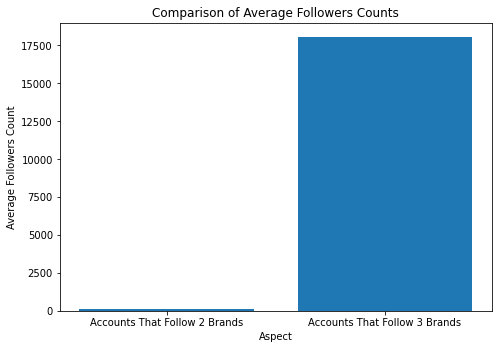

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Accounts That Follow 2 Brands', 'Accounts That Follow 3 Brands']
y = [follow_two_df['followers_count'].mean(), follow_three_df['followers_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Followers Counts')
plt.xlabel("Aspect")
plt.ylabel("Average Followers Count")
plt.show()

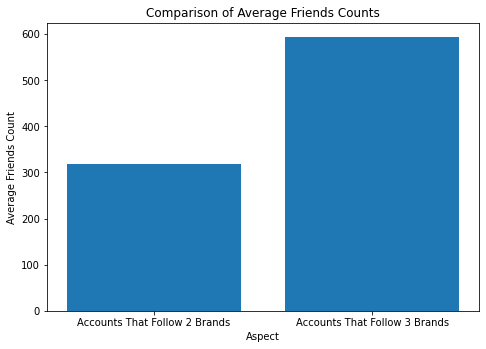

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Accounts That Follow 2 Brands', 'Accounts That Follow 3 Brands']
y = [follow_two_df['friends_count'].mean(), follow_three_df['friends_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Friends Counts')
plt.xlabel("Aspect")
plt.ylabel("Average Friends Count")
plt.show()

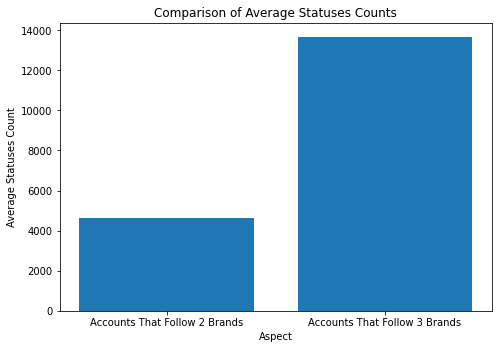

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Accounts That Follow 2 Brands', 'Accounts That Follow 3 Brands']
y = [follow_two_df['statuses_count'].mean(), follow_three_df['statuses_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Statuses Counts')
plt.xlabel("Aspect")
plt.ylabel("Average Statuses Count")
plt.show()

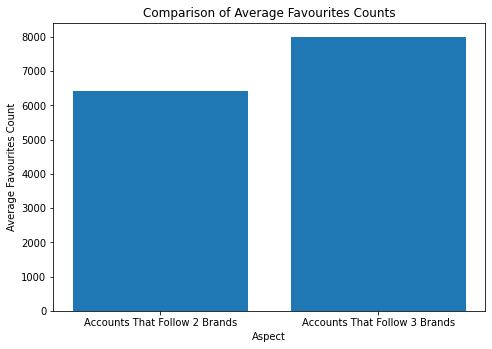

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Accounts That Follow 2 Brands', 'Accounts That Follow 3 Brands']
y = [follow_two_df['favourites_count'].mean(), follow_three_df['favourites_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Favourites Counts')
plt.xlabel("Aspect")
plt.ylabel("Average Favourites Count")
plt.show()

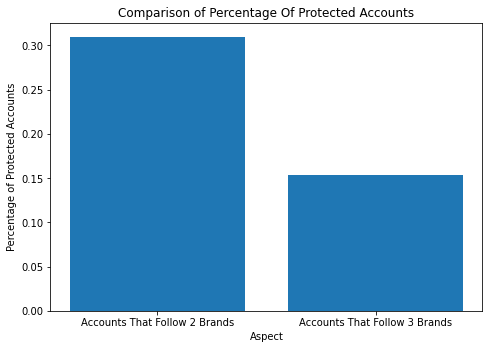

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Accounts That Follow 2 Brands', 'Accounts That Follow 3 Brands']
y = [follow_two_df['protected'].value_counts()[1] / follow_two_df['protected'].value_counts()[0], follow_three_df['protected'].value_counts()[1] / follow_three_df['protected'].value_counts()[0]]
ax.bar(x,y)
plt.title('Comparison of Percentage Of Protected Accounts')
plt.xlabel("Aspect")
plt.ylabel("Percentage of Protected Accounts")
plt.show()

# From the communities, what similarities can be indentified from the information extracted? How would this information be useful to the domain?

In [ ]:
communities = cm.best_partition(G)
nx.set_node_attributes(G, values = communities, name = "modularity")

modularity = {} # Create a new, empty dictionary
for k,v in communities.items(): # Loop through the community dictionary
  if v not in modularity:
    modularity[v] = [k] # Add a new key for a modularity class the code hasn't seen before
  else:
    modularity[v].append(k) # Append a name to the list for a modularity class the code has already seen

In [ ]:
classes = []

for k,v in modularity.items(): # Loop through the new dictionary
  if len(v) > 2: # Filter out modularity classes with 2 or fewer nodes
    print('Class '+str(k)+':', v) # Print out the classes and their members
    class_mod = []

    for item in v:
      for n in nodes:
        if item == n[2]:
          class_mod.append(n)
  classes.append(class_mod)

Class 1: ['Aizzaaattttt', 'Vincent63312644', 'ProfFaris46', 'httpadri4na', 'dokyeomdude', 'jieha_yuki', 'aqxxil', 'felixismylovee', 'yunhannie', 'BelteshazzarD_', 'Anto_Szn', 'hakashiii', 'Harvish_03', 'lilwooahae', 'z__id__', 'navin6015', 'ANATHARAJ7', 'AfifLela', 'ashrxzra', 'hjaetrbl', 'yannyeon', 'jshuaism', 'svt4love', 'lem0nleaf', 'fatinn_aleeya', 'UmairahSyafiqa4', 'SingleBij', 'GI_16172', 'Nisa26161536', 'heartmingyu1', 'sabrinagyu', 'mimgyuz', 'aydan_sc', 'lilydefs', 'RavyahR', 'kwonhoshi156', 'LisaKyu85', 'syabinaz', 'VishwaElago', '_rohacarat', 'dokyeomed', 'Salmandaadhi', 'kyro89553796', 'chilaxdude341', 'kumar_niv', 'Sheebinnn', 'BlueCloud0127', 'whouskat', 'KalaimagalChan1', 'Sabbir11464654', 'Thanush48651854', 'Wardinarizal', 'HishamNisfu', 'mikeydeym', 'Firdaus40569008', 'bluecidthot', 'catalliyaidle', 'Cikw4ny13', 'abcdef123456x1', 'batmanathan_k', 'no_namefornow_', 'aynazmsh', 'Sathish17015976', 'audrey_c0806', 'annaliana22', 'SitiSal50981114', 'Zzzz56230510', 'meotji

In [ ]:
for c in classes:
  class_df = pd.DataFrame(c, columns = ['id_str', 'name', 'screen_name', 'location', 'description', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'time_zone', 'verified', 'statuses_count', 'lang', 'contributors_enabled', 'profile_image_url'])
  cinema_name = c[-1][2]
  class_df.to_csv(cinema_name+'_communities.csv', index=False)

In [ ]:
class0_df = pd.read_csv('communities_class0.csv')
class1_df = pd.read_csv('communities_class1.csv')
class2_df = pd.read_csv('communities_class2.csv')

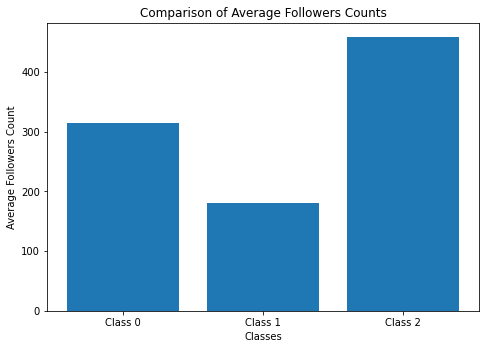

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Class 0', 'Class 1', 'Class 2']
y = [class0_df['followers_count'].mean(), class1_df['followers_count'].mean(), class2_df['followers_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Followers Counts')
plt.xlabel("Classes")
plt.ylabel("Average Followers Count")
plt.show()

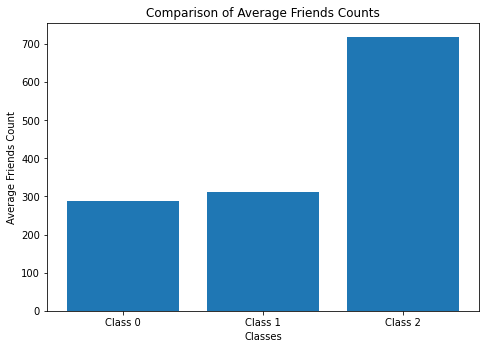

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Class 0', 'Class 1', 'Class 2']
y = [class0_df['friends_count'].mean(), class1_df['friends_count'].mean(), class2_df['friends_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Friends Counts')
plt.xlabel("Classes")
plt.ylabel("Average Friends Count")
plt.show()

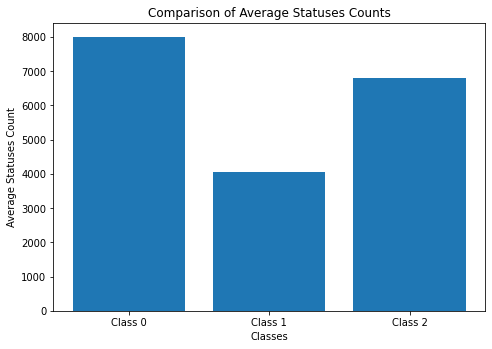

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Class 0', 'Class 1', 'Class 2']
y = [class0_df['statuses_count'].mean(), class1_df['statuses_count'].mean(), class2_df['statuses_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Statuses Counts')
plt.xlabel("Classes")
plt.ylabel("Average Statuses Count")
plt.show()

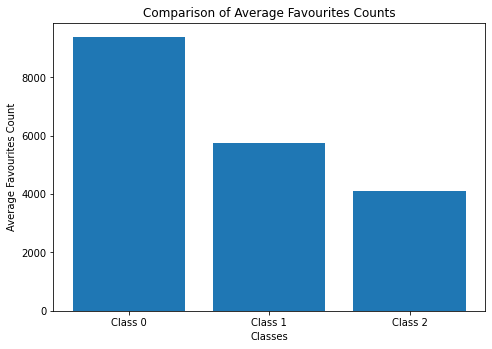

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Class 0', 'Class 1', 'Class 2']
y = [class0_df['favourites_count'].mean(), class1_df['favourites_count'].mean(), class2_df['favourites_count'].mean()]
ax.bar(x,y)
plt.title('Comparison of Average Favourites Counts')
plt.xlabel("Classes")
plt.ylabel("Average Favourites Count")
plt.show()

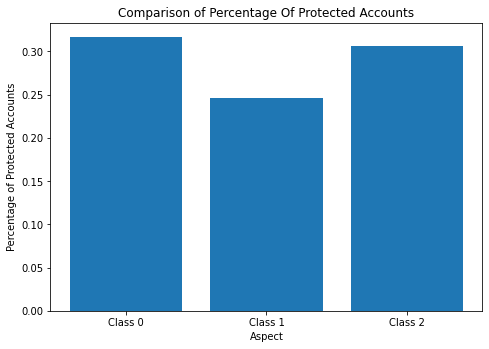

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Class 0', 'Class 1', 'Class 2']
y = [class0_df['protected'].value_counts()[1] / class0_df['protected'].value_counts()[0], class1_df['protected'].value_counts()[1] / class1_df['protected'].value_counts()[0], class2_df['protected'].value_counts()[1] / class2_df['protected'].value_counts()[0]]
ax.bar(x,y)
plt.title('Comparison of Percentage Of Protected Accounts')
plt.xlabel("Aspect")
plt.ylabel("Percentage of Protected Accounts")
plt.show()